In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords


In [17]:
# Simulasi label (ubah dengan label asli kamu!)
# 1: positif, 0: netral, -1: negatif
#df['label'] = np.random.choice([1, 0, -1], size=len(df))  

import pandas as pd
from textblob import TextBlob

# Membaca dataset
df = pd.read_csv("Translated_Scrapping.csv")

# Fungsi untuk menentukan label sentimen
def get_sentiment(text):
    if isinstance(text, str) and text.strip() != "":
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        if polarity > 0:
            return "positive"
        elif polarity < 0:
            return "negative"
        else:
            return "neutral"
    else:
        return "neutral"

# Terapkan ke kolom
df['label'] = df['translated_text'].apply(get_sentiment)

# Simpan hasil
#df.to_csv("Labeled_Sentiment.csv", index=False)

#print("Sentimen selesai dilabeli! Dataset disimpan sebagai 'Labeled_Sentiment.csv'.")
df.head()

,full_text,clean_text,translated_text,label
0,@heathengangs Mulai membaikmi fashion sense mu...,membaikmi fashion sense mu mmg nda berkiblat s...,Improve your fashion sense mmg mmg and the rib...,neutral
1,@chiseiyuu @21of12 dia satria mahatir ver jemb...,satria mahatir ver jember cin,Satria Mahatir Ver Jember Cin,neutral
2,@nativora @manukacaramel Udah di posting si sa...,udah posting si satria mahatir,Already posted the Satria Mahatir,neutral
3,knp sih dia demen bgt pake hoodie gaya satria ...,knp sih demen bgt pake hoodie gaya satria mahatir,why is it really like using the hoodie style o...,positive
4,@deduys kembaran satria mahatir ditolak sp yg ...,kembaran satria mahatir ditolak sp yg ga kaget...,Kembatan Satria Mahatir was rejected SP who wa...,negative


In [18]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Pastikan kolom clean_text adalah string dan tidak kosong
df['clean_text'] = df['clean_text'].astype(str)
df = df[df['clean_text'].str.strip() != '']

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['clean_text'])

# Tokenizing
sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index

# Padding
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# One-hot label
y = pd.get_dummies(df['label']).values


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
df['label'].value_counts()


label
neutral     2324
positive     506
negative     322
Name: count, dtype: int64

In [20]:
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))

model.add(Dropout(0.5))

model.add(LSTM(32, dropout=0.6, recurrent_dropout=0.4))

model.add(Dense(3, activation='softmax'))  # 3 kelas: positif, netral, negatif

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

C:\Users\Nettaanell D\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,123 (3.88 MB)

 Trainable params: 1,017,123 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.6775 - loss: 0.9164 - val_accuracy: 0.7369 - val_loss: 0.6564
Epoch 2/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.7404 - loss: 0.6441 - val_accuracy: 0.7385 - val_loss: 0.6008
Epoch 3/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.7527 - loss: 0.6030 - val_accuracy: 0.7639 - val_loss: 0.5870
Epoch 4/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - accuracy: 0.7641 - loss: 0.5726 - val_accuracy: 0.7718 - val_loss: 0.5767
Epoch 5/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.7834 - loss: 0.5687 - val_accuracy: 0.7829 - val_loss: 0.5611
Epoch 6/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7926 - loss: 0.5483 - val_accuracy: 0.7924 - val_loss: 0.5411
Epoch 7/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.8058 - loss: 0.4907 - val_accuracy: 0.8162 - val_loss: 0.5178
Epoch 8/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - accuracy: 0.8257 - loss: 0.4673 - val_accura

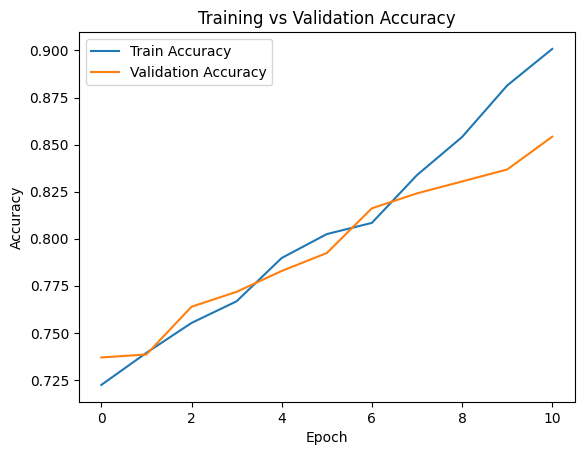

In [21]:
history = model.fit(X_train, y_train,
                    epochs=11,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Akurasi Test Set: 85.42%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
              precision    recall  f1-score   support

     Negatif       0.85      0.26      0.40        65
      Netral       0.90      0.97      0.93       465
     Positif       0.66      0.70      0.68       101

    accuracy                           0.85       631
   macro avg       0.80      0.64      0.67       631
weighted avg       0.85      0.85      0.84       631



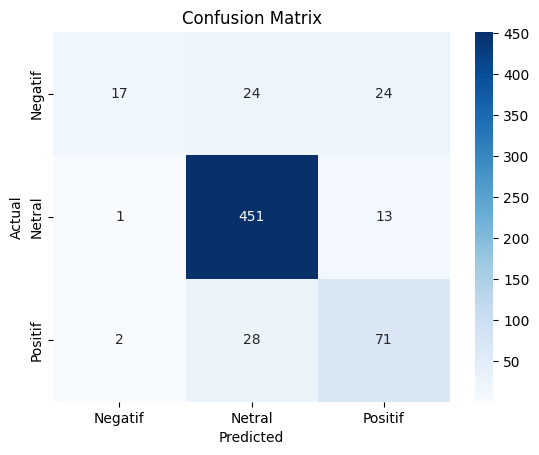

In [22]:
# Akurasi
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi Test Set: {accuracy * 100:.2f}%")

# Laporan klasifikasi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
